# Atividade 8 - Arquitetura de Computadores - PPGI

Aluno: Victor José de Sousa Koehler

Matrícula: 20211023501

## Introdução

Neste trabalho é apresentado um breve estudo sobre a utilização de técnicas de paralelismo em um conjunto simples de algoritmos de Processamento Digital de Imagens. Mais especificamente, esta é uma continuação do repositório [https://github.com/VictorKoehler/PPGI-ARQ-A5ImageBenchmark](https://github.com/VictorKoehler/PPGI-ARQ-A5ImageBenchmark) contendo modificações para habilitar o paralelismo dos métodos implementados através da API OpenMP. Ainda neste documento, são exibidos gráficos e tabelas comparativas dos experimentos computacionais realizados sobre a implementação original e as modificações propostas, de acordo com seus parâmetros.

Os códigos de interesse foram implementados na linguagem C++, na versão mínima C++17, compilados utilizando GNU GCC versão 9.4.0 (9.4.0-1ubuntu1~20.04.1) e testados em um computador executando o sistema operacional Ubuntu 20.04.1, kernel Linux versão 5.13.0-44-generic#49, equipado com 8GB de RAM e processador Intel Core i5 7200U que possui dois núcleos físicos, cada um capaz de executar simultaneamente duas threads pela tecnologia *Hyper-Threading*, totalizando 4 núcleos virtuais.



A base de código possui duas dependências externas:

- TCLAP (Licença MIT): http://tclap.sourceforge.net/
- CImg (Licença CeCILL-C/CeCILL ): https://cimg.eu/

## Metodologia

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import io
from os import listdir as os_listdir

sns.set_theme(style="darkgrid")

In [3]:
df_ = pd.read_csv('log.csv', sep=', ', engine='python', comment='#', names=['implementation', 'variant', 'file', 'width', 'height', 'channels', 'time'])
_unit_df, _unit_df_eng = 'milisegundos', 'milliseconds'

def df_time_def(i):
    v, u = i.split(' ')
    u_ = {'seconds': 1, 'milliseconds': 0.001, 'microseconds': 10**(-6), 'nanoseconds': 10**(-9)}
    # u_ = {'seconds': 10**(6), 'milliseconds': 100, 'microseconds': 1, 'nanoseconds': 0.001}
    return float(v)*u_[u]/u_[_unit_df_eng]
# df_

In [4]:
def df_gen(df_):
    df = df_.copy()
    df.time = df.time.apply(df_time_def)
    df['threads'] = df.implementation.apply(lambda x: int(x.split('_')[-1]) if 'parallel' in x else 1)
    df['implementation_'] = df.implementation.apply(lambda w: w.replace('log_', '').replace('log', 'optimized').replace('_', ' '))
    df.implementation = df.implementation.apply(lambda w: w.replace('log_', '').replace('log', 'optimized').split('_')[0])
    # df = pd.concat([pd.DataFrame(list(df['implementation'].str.split('@')), columns=['impl_strat', 'impl_access']), df], axis=1)
    df['D'] = df[['width', 'height', 'channels']].prod(axis=1)
    df = df[df['D'] != 36]
    return df
df = df_gen(df_)

Foram utilizadas 21 imagens de alta definição (sendo algumas delas variantes redimensionadas de outra). Todas são carregadas sem compressão na memória principal. Além disso, os filtros sempre trabalham sobre um *buffer* de mesmo tamanho da imagem original, o que implica que o teto de consumo de memória é (ligeiramente maior que) o dobro da quantidade de *pixels* (largura X altura X canais). A tabela abaixo relaciona a dimensão de cada imagem:

In [5]:
_df1 = df.pivot_table(values='time', index='file', columns=['implementation'], aggfunc='mean')
df[['file', 'width', 'height', 'channels', 'D']].drop_duplicates().rename(
    {'width': 'largura', 'height': 'altura', 'channels': 'canais', 'D': 'Dimensões ( = largura * altura * canais)', 'file': 'Arquivo'}, axis=1).set_index('Arquivo')

,largura,altura,canais,Dimensões ( = largura * altura * canais)
Arquivo,,,,
input/166370483-56cb36da5f9b5879cc54103c_1k.jpg,1000,666,3,1998000
input/166370483-56cb36da5f9b5879cc54103c_2k.jpg,2000,1333,3,7998000
input/166370483-56cb36da5f9b5879cc54103c.jpg,5760,3840,3,66355200
input/Airbus_Pleiades_50cm_8bit_RGB_Yogyakarta.jpg,5494,5839,3,96238398
input/Airbus-Spot6-50cm-St-Benoit-du-Lac-Quebec-2014-09-04.jpg,5181,4828,3,75041604
input/Everest_kalapatthar_1k.jpg,1152,1012,3,3497472
input/Everest_kalapatthar_2k.jpg,2304,2025,3,13996800
input/Everest_kalapatthar.jpg,2304,3456,3,23887872
input/Foto-011.tif,2784,1891,3,15793632


### Modificações introduzidas

O commit cb7ba874acf1ee5968b2b96a79d4a0cd276a6a1d introduziu as seguintes modificações no arquivo `src/ImagingAlgorithms.hpp`, como visto na imagem mais abaixo: Quando `PARALLELIZE` é especificado durante a compilação, o *header* do OpenMP é incluído e a macro `ONLY_IN_PARALLEL` é definida de modo a expandir para o parâmetro `x` fornecido; Do contrário, `ONLY_IN_PARALLEL` suprime os parâmetros, resultando em uma expansão vazia. Como resultado, as *macros* `biforT` e `triforT` expandem, respectivamente, para *for*s aninhados duplos e triplos, que, quando compilados com `PARALLELIZE`, são automaticamente colapsados em um único *loop* de forma a gerar um único e uniforme espaço de iteração paralelizavel pela API através dos *pragmas* `omp parallel for collapse(X)`, onde `X` corresponde a quantidade de *for*s aninhados. Considerando que todos os métodos implementados fazem uso direta ou indiretamente dessas *macros*, estas alterações são suficientes para permitir tirar proveito dos múltiplos núcleos de processadores modernos.

![Modificações introduzidas](ImagingAlgorithms.hpp.diff.png "Modificações introduzidas")

### Comparação entre diferentes perfis de otimização e paralelismo

Nos resultados dos experimentos apresentados na seção seguinte, três perfis de compilação foram utilizados através das configurações especificadas no arquivo `Makefile`:

- *debug*, que utiliza as seguintes opções de compilação: `g++ -O0 -DONDEBUG -fno-omit-frame-pointer -fsanitize=address -fsanitize=leak -fsanitize=null -fsanitize=signed-integer-overflow -g3 -DGITFLAG -Wall -Wextra -Wl,--no-relax -std=c++17 -m64 -fPIC -fno-strict-aliasing -fexceptions -DIL_STD`.

- *optimized*, que utiliza as seguintes opções de compilação: `g++ -O3 -DNDEBUG -march=native -ffast-math -DGITFLAG -Wall -Wextra -Wl,--no-relax -std=c++17 -m64 -fPIC -fno-strict-aliasing -fexceptions -DIL_STD`.

- *parallel*, que utiliza as seguintes opções de compilação: `g++ -O3 -DNDEBUG -march=native -ffast-math -DPARALLELIZE -fopenmp -DGITFLAG -Wall -Wextra -Wl,--no-relax -std=c++17 -m64 -fPIC -fno-strict-aliasing -fexceptions -DIL_STD`.

Note que *parallel* possui as mesmas opções de compilação que *optimized*, mas este último suporta apenas a execução *single thread* devido a expansão da macro `ONLY_IN_PARALLEL`.

## Experimentos

A tabela abaixo apresenta os resultados relacionando a dimensão em *bytes* da imagem (linha), por cada perfil/quantidade de *threads* (coluna) em função da soma do tempo de execução de todos os filtros (valores).

In [6]:
_df2_gen = lambda df: df.pivot_table(values='time', index='D', columns=['implementation', 'threads'], aggfunc='mean')
_df2 = _df2_gen(df)
_df2

implementation       debug  optimized   parallel                         \
threads                  1          1          2           4          6   
D                                                                         
996360            1904.335    157.900     61.603     57.1530     57.160   
1998000           3708.419    198.458     83.175     83.1130    210.872   
3497472           6479.452    330.837    165.435    173.3560    278.360   
7998000          14683.338    531.527    362.544    374.0440    419.813   
13996800         25888.416   1004.068    649.217    522.5640    596.857   
15793632         29364.150   1262.688    825.172    633.5500    648.440   
23887872         43964.618   1704.802   1171.597    902.6730    909.736   
24883200         47762.424   1731.849   1191.023    959.5750    967.724   
33350616         62839.326   2198.731   1431.982   1243.3090   1295.000   
50900328         94893.421   3380.960   2193.408   1877.1130   1851.044   
63078912        116471.280   3481.287   2275.667   2036.6370   2112.766   
66355200        121518.079   4038.407   2326.898   2170.7580   2229.945   
69336000        128195.941   4623.138   2926.619   2555.8190   2580.089   
75041604        138481.116   5037.230   3251.403   2681.3370   2733.090   
88347468        167265.678   6490.426   4117.695   3330.7510   3432.155   
96238398        179235.953   7322.508   4701.228   3794.2120   3847.353   
155021268       285839.037  11088.341   7059.564   5854.6460   5932.820   
198770616       368809.892  15055.568   9545.877   7667.2520   7764.806   
215046633       400663.638  13564.259   9309.164   7832.8045   7634.529   
217950336       403925.139  12060.683   7697.845   6961.2850   6915.632   
244131570       450069.526  17281.750  11065.986   9233.9630   9179.828   
296258490       547251.163  21349.470  13329.146  11080.0410  11055.223   
353425410       664393.786  25321.964  16175.745  13294.4470  13466.493   

implementation              
threads                  8  
D                           
996360             54.7420  
1998000           192.3740  
3497472           143.5370  
7998000           398.7400  
13996800          590.9500  
15793632          635.1110  
23887872          889.3250  
24883200          968.1730  
33350616         1243.3590  
50900328         1859.5150  
63078912         2015.9400  
66355200         2104.2470  
69336000         2506.8990  
75041604         2672.5970  
88347468         3375.4380  
96238398         3770.8010  
155021268        5846.6270  
198770616        7711.9080  
215046633        7494.9435  
217950336        6907.6210  
244131570        9102.5750  
296258490       10984.5610  
353425410       13202.7390

A mesma tabela anterior, mas ordenada de modo que a estratégia mais a esquerda possui o menor tempo computacional total/médio:

In [7]:
def _df2s_gen(df):
    _df2s = _df2_gen(df)
    _df2s.loc['mean'] = _df2s.mean(numeric_only=True, axis=0)
    _df2s.sort_values(by='mean', axis=1, inplace=True)
    _df2s.drop('mean', inplace=True)
    return _df2s
_df2s = _df2s_gen(df)
_df2s

implementation    parallel                                    optimized  \
threads                  8           4          6          2          1   
D                                                                         
996360             54.7420     57.1530     57.160     61.603    157.900   
1998000           192.3740     83.1130    210.872     83.175    198.458   
3497472           143.5370    173.3560    278.360    165.435    330.837   
7998000           398.7400    374.0440    419.813    362.544    531.527   
13996800          590.9500    522.5640    596.857    649.217   1004.068   
15793632          635.1110    633.5500    648.440    825.172   1262.688   
23887872          889.3250    902.6730    909.736   1171.597   1704.802   
24883200          968.1730    959.5750    967.724   1191.023   1731.849   
33350616         1243.3590   1243.3090   1295.000   1431.982   2198.731   
50900328         1859.5150   1877.1130   1851.044   2193.408   3380.960   
63078912         2015.9400   2036.6370   2112.766   2275.667   3481.287   
66355200         2104.2470   2170.7580   2229.945   2326.898   4038.407   
69336000         2506.8990   2555.8190   2580.089   2926.619   4623.138   
75041604         2672.5970   2681.3370   2733.090   3251.403   5037.230   
88347468         3375.4380   3330.7510   3432.155   4117.695   6490.426   
96238398         3770.8010   3794.2120   3847.353   4701.228   7322.508   
155021268        5846.6270   5854.6460   5932.820   7059.564  11088.341   
198770616        7711.9080   7667.2520   7764.806   9545.877  15055.568   
215046633        7494.9435   7832.8045   7634.529   9309.164  13564.259   
217950336        6907.6210   6961.2850   6915.632   7697.845  12060.683   
244131570        9102.5750   9233.9630   9179.828  11065.986  17281.750   
296258490       10984.5610  11080.0410  11055.223  13329.146  21349.470   
353425410       13202.7390  13294.4470  13466.493  16175.745  25321.964   

implementation       debug  
threads                  1  
D                           
996360            1904.335  
1998000           3708.419  
3497472           6479.452  
7998000          14683.338  
13996800         25888.416  
15793632         29364.150  
23887872         43964.618  
24883200         47762.424  
33350616         62839.326  
50900328         94893.421  
63078912        116471.280  
66355200        121518.079  
69336000        128195.941  
75041604        138481.116  
88347468        167265.678  
96238398        179235.953  
155021268       285839.037  
198770616       368809.892  
215046633       400663.638  
217950336       403925.139  
244131570       450069.526  
296258490       547251.163  
353425410       664393.786

A mesma tabela ordenada anterior, mas colorida e anotada com as somatórias das linhas e colunas (a direita e em baixo), bem como inclui uma linha extra com a porcentagem relativa a implementação de melhor desempenho:

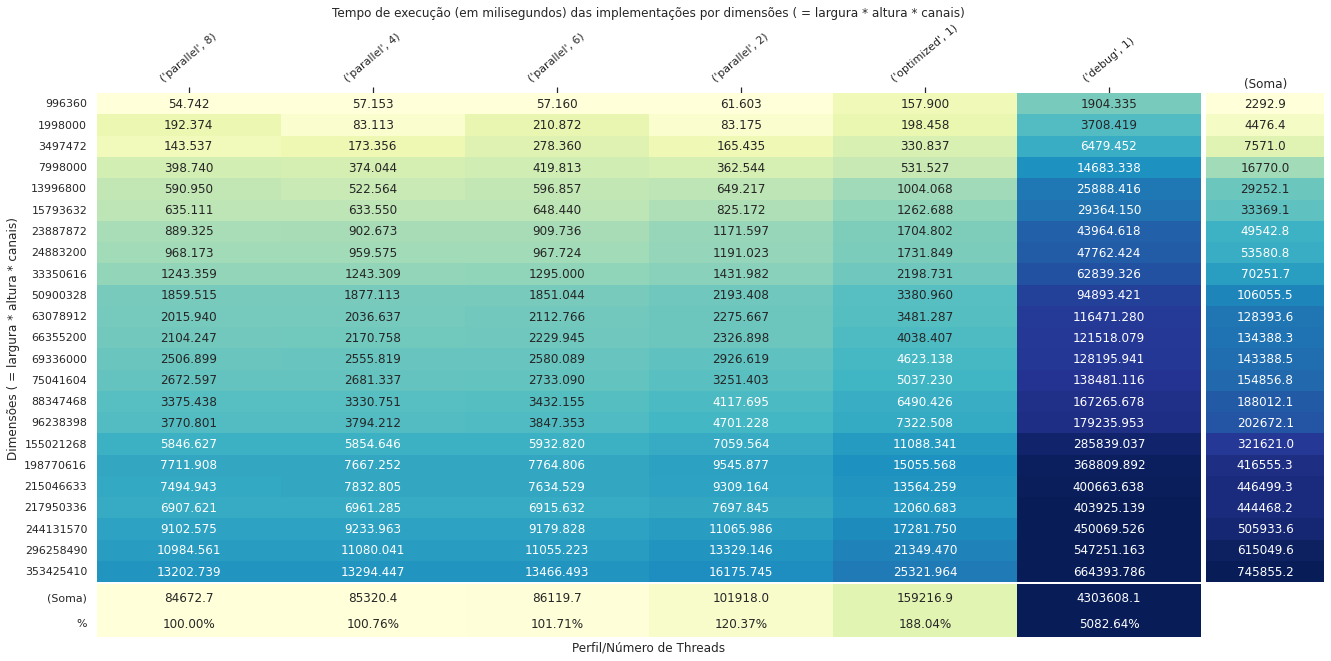

In [8]:
def _df2s_heatmap(_df2s):
    fig_sz = (22, 10)
    fig = plt.figure(figsize=fig_sz)
    fig_d, fig_d1, fig_u1 = 40, 36, 4
    ax1 = plt.subplot2grid((fig_d, fig_d), (0, 0), colspan=fig_d1, rowspan=fig_d1, title='Tempo de execução (em '+_unit_df+') das implementações por dimensões ( = largura * altura * canais)')
    axb = plt.subplot2grid((fig_d, fig_d), (fig_d1, 0), colspan=fig_d1, rowspan=fig_u1)
    axr = plt.subplot2grid((fig_d, fig_d), (0, fig_d1), colspan=fig_u1, rowspan=fig_d1)

    _g = sns.heatmap(np.log(_df2s), annot=_df2s, ax=ax1, fmt='.3f', robust=True, cmap="YlGnBu", linecolor='b', cbar = False)
    _g.set_facecolor('xkcd:salmon')
    # sns.heatmap(pv, ax=ax1, annot=True, cmap="YlGnBu",mask=mask, linecolor='b', cbar = False)
    ax1.xaxis.tick_top()
    ax1.set_xticklabels(_df2s.columns,rotation=40)
    def __hmap_sides(d, axis, colorvalue=False):
        r = pd.DataFrame(d.sum(axis=axis))
        if colorvalue:
            if axis == 0: r['%'] = r
            r = np.log(r)
        elif axis == 0:
            class DummyStrFormater(str):
                def __init__(self, s):
                    self.s = s            
                def __format__(self, fmt):
                    return self.s

            r['%'] = (r/r.min()).applymap(lambda x: DummyStrFormater('{:.2f}%'.format(100*x)))
        return r.transpose() if axis == 0 else r

    sns.heatmap(__hmap_sides(_df2s, 0, True), annot=__hmap_sides(_df2s, 0), ax=axb, fmt='.1f', robust=True, cmap="YlGnBu", cbar=False, xticklabels=False)
    sns.heatmap(__hmap_sides(_df2s, 1, True), annot=__hmap_sides(_df2s, 1), ax=axr, fmt='.1f', robust=True, cmap="YlGnBu", cbar=False, xticklabels=False, yticklabels=False)
    ax1.set_ylabel('Dimensões ( = largura * altura * canais)')
    axb.set_xlabel('Perfil/Número de Threads')
    axr.set_ylabel('')
    axr.set_title('(Soma)')
    axb.set_yticklabels(['(Soma)', '%'], rotation=0)
    # _ = snsheatmap(np.log(_df2s), title='', xlabel='')

_df2s_heatmap(_df2s)

É possível observar nas tabelas que a utilização correta de perfis de otimização possui o maior impacto no tempo de execução, onde pode-se constatar que, no total, o perfil `debug` demandou 71 minutos de execução para completar a série de experimentos, enquanto que o perfil `optimized` *single-thread* exigiu apenas 2 minutos e 39 segundos (159 segundos). Por sua vez, habilitar o programa para execução paralela reduziu o tempo de execução em 1 minuto (101 segundos) quando utilizada 2 *threads*, que corresponde a quantidade de núcleos físicos do processador em questão. Em contrapartida, ao fazer-se uso de todos os 4 núcleos virtuais, a série de experimentos é realizada em média a 1 minuto e 25 segundos (85 segundos), independente de quantas *threads* sejam alocadas devido a escassez dos recursos, como pode ser observado nas execuções de 6 e 8 *threads*.


Por fim, os gráficos a seguir apresentam uma visão das tabelas apresentadas anteriormente:

In [9]:
def default_plot(title='', xlabel=None, ylabel=None, invok=None, figsize=(16, 10), **kwargs):
    fig = plt.gcf()
    fig.set_size_inches(*figsize)
    fig.set_facecolor('white')
    if invok is not None: invok(fig, **kwargs)
    plt.title(title)
    if xlabel: plt.xlabel(xlabel)
    if ylabel: plt.ylabel(ylabel)
    return fig

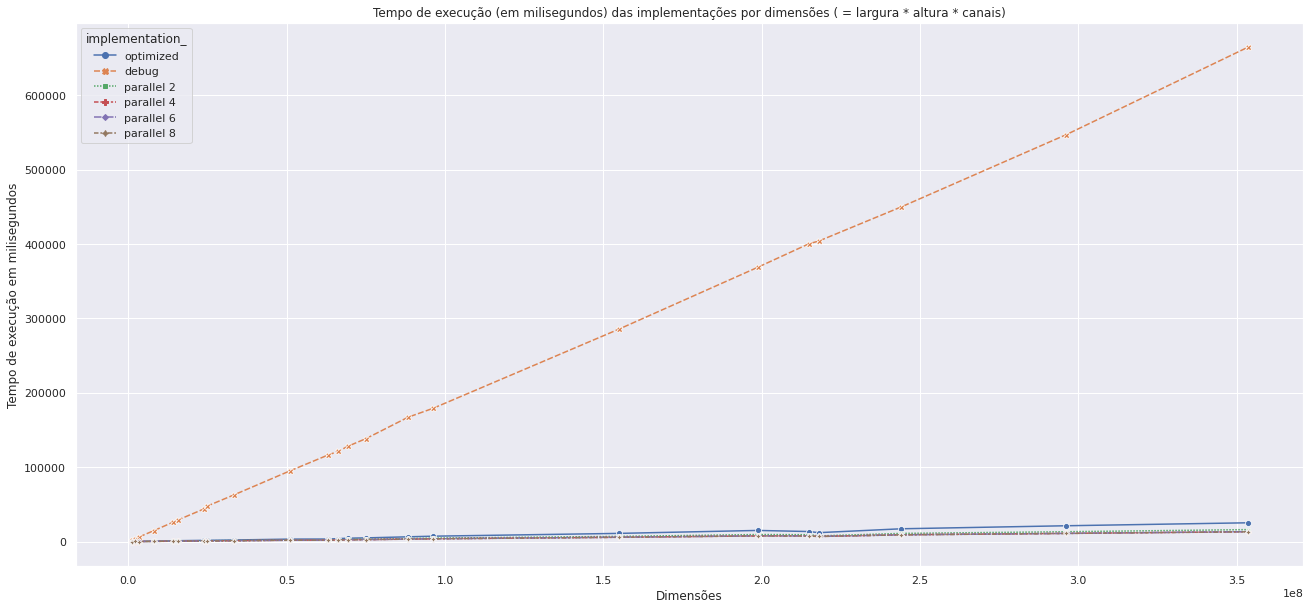

In [11]:
def _plot_linegraph(df, extr='', ret=False, set_xlim=None, set_ylim=None, lim_autoadjust=True):
    default_plot('Tempo de execução (em '+_unit_df+') das implementações por dimensões ( = largura * altura * canais)' + extr,
        'Dimensões', 'Tempo de execução em '+_unit_df, figsize=(22, 10))
    # grid = sns.pointplot(x="D", y="time", hue="impl_access", linestyle="impl_strat", data=df)
    # grid.set(xscale="log", yscale="log")
    r = sns.lineplot(x="D", y="time", markers=True, hue='implementation_', style="implementation_", data=df)
    if set_xlim:
        r.set_xlim(*set_xlim)
        if lim_autoadjust and not set_ylim:
            rdf = df[(set_xlim[0] <= df['D']) & (df['D'] <= set_xlim[1])]['time']
            padd = 0.05*(rdf.max() - rdf.min())
            r.set_ylim(rdf.min() - padd, rdf.max() + padd)
    if set_ylim:
        r.set_ylim(*set_ylim)
        if lim_autoadjust and not set_xlim:
            rdf = df[(set_ylim[0] <= df['time']) & (df['time'] <= set_ylim[1])]['D']
            r.set_xlim(rdf.min() - padd, rdf.max() + padd)
    if ret: return r
_df = df
_plot_linegraph(_df)

Como o perfil `debug` está visivelmente predominando a escala do gráfico acima, o mesmo foi suprimido dos seguintes:

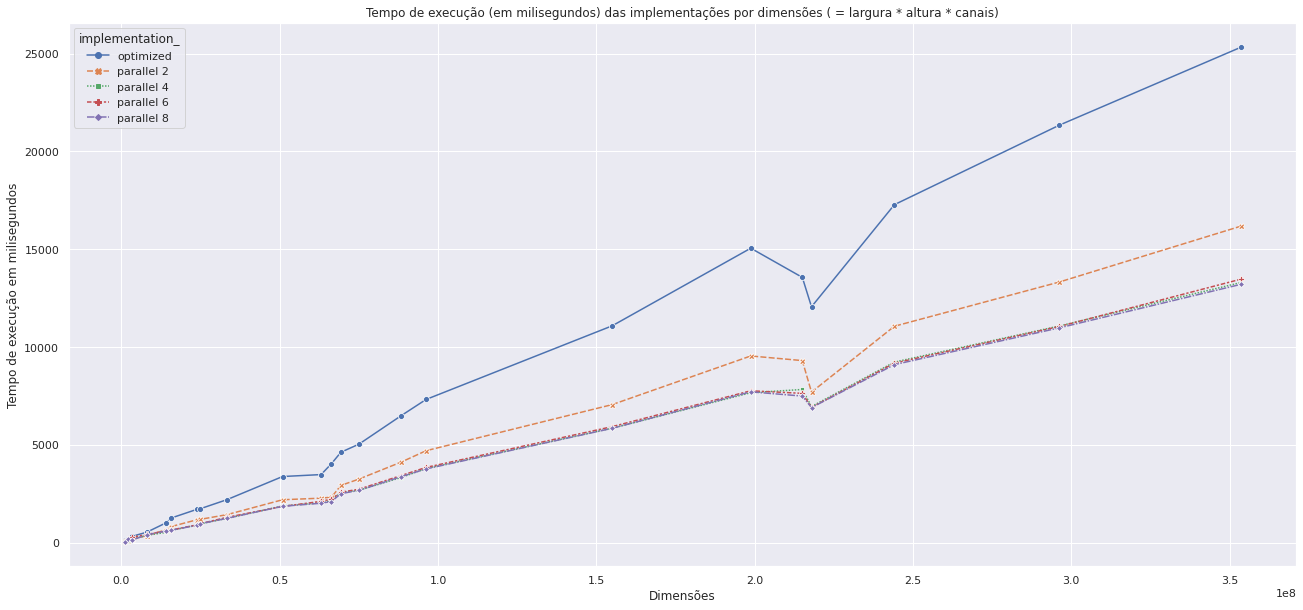

In [12]:
df = _df[_df['implementation_'] != 'debug']
_plot_linegraph(df)

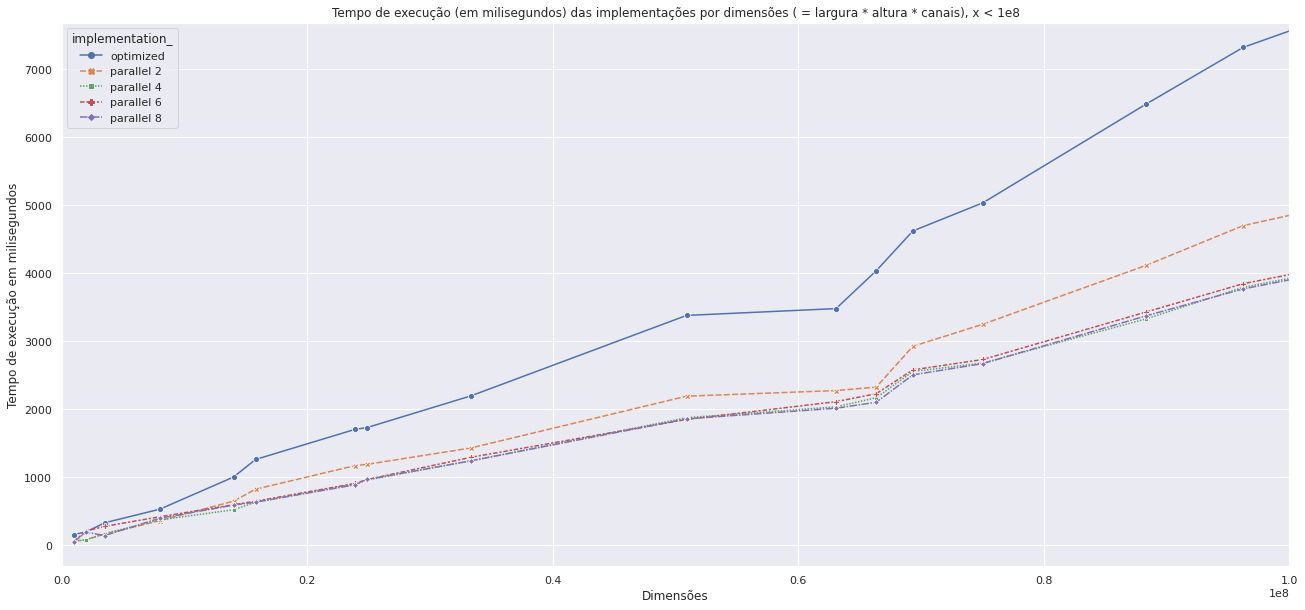

In [13]:
_plot_linegraph(df, ', x < 1e8', set_xlim=(0, 10**8))

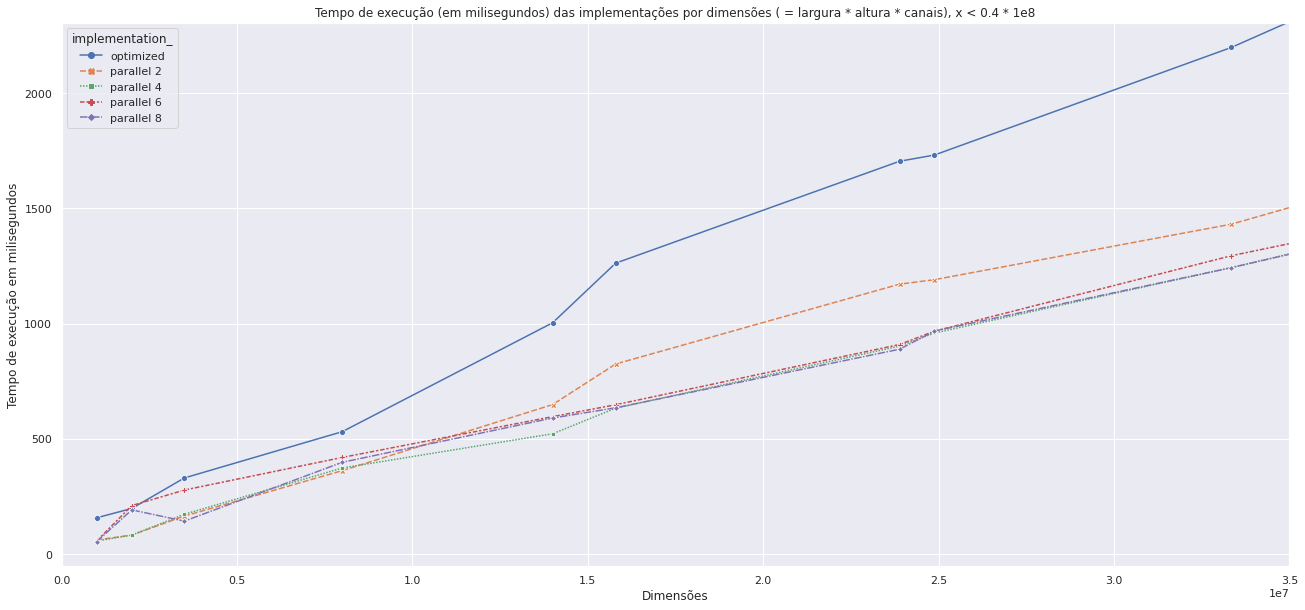

In [14]:
_plot_linegraph(df, ', x < 0.4 * 1e8', set_xlim=(0, 0.35*10**8))

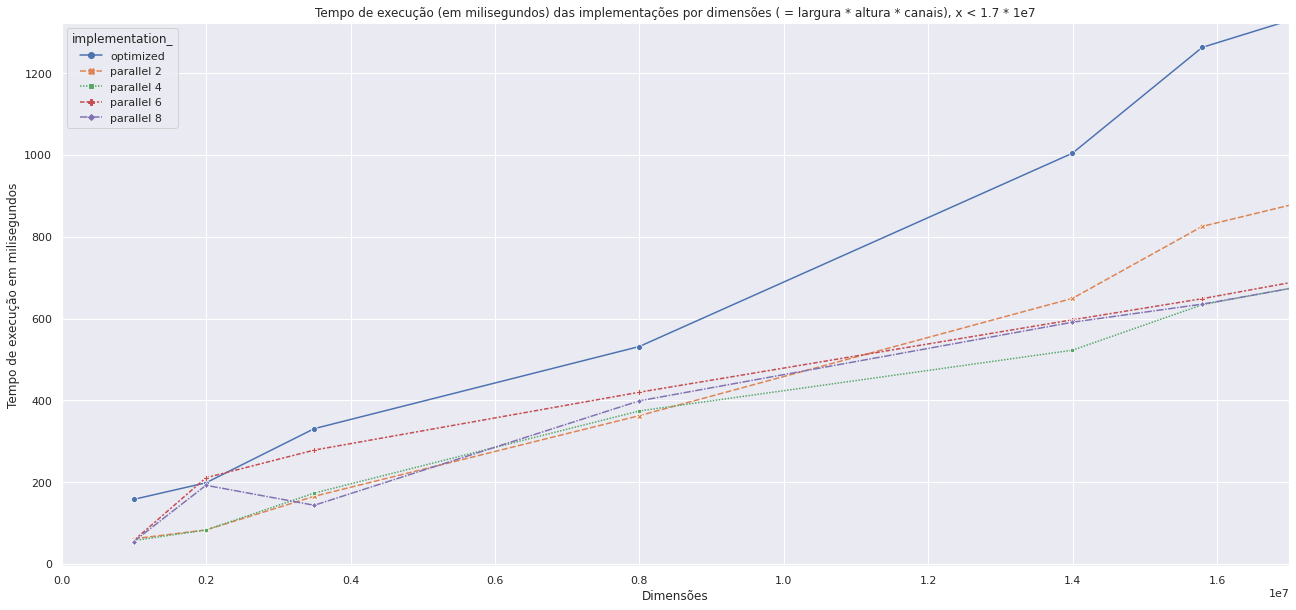

In [15]:
_plot_linegraph(df, ', x < 1.7 * 1e7', set_xlim=(0, 1.7*10**7))

### Monitor de Desempenho

A captura de tela exibida a seguir registra o histórico de uso de CPU e memória principal da execução da versão paralela do programa fixado em 8 *threads*. Note que a execução de fato do algoritmo começa apenas após a linha vermelha pontilhada, ponto a qual todos os quatro núcleos virtuais passam a ser usados em suas totalidades, sendo essa fase precedida pela rotina de leitura da imagem.

![Monitor de Desempenho - 8 Threads](syslog_8threads.png "Monitor de Desempenho - 8 Threads")

Um comportamento semelhante, mas não tão bem delimitado, pode ser observado durante a exeução do algoritmo com 2 threads:

![Monitor de Desempenho - 2 Threads](syslog_2threads.png "Monitor de Desempenho - 2 Threads")